10. 번역기를 만들어보자

<<목차>>

1) 정제, 정규화, 전처리 (영어, 프랑스어 모두!)  

2) 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

3) 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

4) 임베딩 층(Embedding layer) 사용하기

5) 모델 구현하기

6) 모델 평가하기

7) 시각화

8) 루브릭

9) 회고

https://www.manythings.org/anki/

사용할 데이터는  프랑스어와 영어의 병렬 코퍼스인 fra-eng.zip

In [18]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense, Dropout
from tensorflow.keras.models import Model


1) 정제, 정규화, 전처리

In [19]:
file_path = '/home/june/data/translator_seq2seq/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print("전체 샘플의 수 : ", len(lines))
lines.sample(5)

전체 샘플의 수 :  197463


,eng,fra,cc
39959,Who locked the door?,Qui a verrouillé la porte ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
88047,I think we're pretty lucky.,Je pense que nous avons pas mal de chance.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
42853,I need a clean shirt.,J'ai besoin d'une chemise propre.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
108036,Are you sure they can do this?,Es-tu sûre qu'elles peuvent faire ça ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
39384,We can win this war.,Nous pouvons gagner cette guerre.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [20]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
13239,Can I pay later?,Puis-je payer plus tard?
1131,I'd leave.,Je partirais.
40921,Did you behave today?,Tu t'es bien tenu aujourd'hui ?
9459,You're a doll!,Vous êtes un amour !
40056,Why did we say that?,Pourquoi avons-nous dit cela ?


In [21]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'

lines.fra = lines.fra.apply(lambda x : '\t ' + x + ' \n')
print("전체 샘플 수 : ", len(lines))
lines.sample(5)

전체 샘플 수 :  50000


,eng,fra
13350,Did he go there?,\t S'y est-il rendu ? \n
174,Be nice.,\t Soyez gentille ! \n
7674,I woke you up.,\t Je t'ai réveillé. \n
22555,Your room is big.,\t Ta chambre est grande. \n
25087,It was impressive.,\t C'était impressionnant. \n


In [22]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    return sentence

In [23]:
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    sentence = sentence.split(" ")
    
    return sentence

In [24]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))

lines.eng.sample(5)

13199           [bite, the, bullet, .]
27752        [you, are, very, rich, .]
19706         [it, was, a, mistake, .]
43066    [i, think, they, like, me, .]
39557     [we, ll, find, out, soon, .]
Name: eng, dtype: object

In [25]:
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

lines.fra.sample(5)

19280    [<start>, je, ferai, n, importe, quoi, ., <end>]
30431    [<start>, je, ne, dirai, pas, un, mot, ., <end>]
41831    [<start>, il, a, t, envoy, en, prison, ., <end>]
16455               [<start>, tom, tait, utile, ., <end>]
18547         [<start>, je, ne, t, ai, pas, vu, ., <end>]
Name: fra, dtype: object

3) 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [26]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:5]

[[33, 1], [33, 1], [33, 1], [33, 1], [908, 1]]

In [27]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
target_text[:5]

[[1, 89, 15, 2],
 [1, 458, 3, 2],
 [1, 30, 649, 15, 2],
 [1, 935, 15, 2],
 [1, 936, 15, 2]]

In [28]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 5987
프랑스어 단어장의 크기 : 9313


In [29]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 19


In [30]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)   
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 5987
프랑스어 단어장의 크기 : 9313
영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 19


In [31]:
sos_token = '<start>'
eos_token = '<end>'

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [32]:
def pad_tensor(tensor):
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = max(num_tokens)
#     max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    tensor = pad_sequences(tensor, padding='post', maxlen=maxlen)  
    return tensor

In [33]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

print("영어 데이터의 크기(shape) :", np.shape(encoder_input))
print("프랑스어 입력 데이터의 크기(shape) :", np.shape(decoder_input))
print("프랑스어 출력 데이터의 크기(shape) :", np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 9)
프랑스어 입력 데이터의 크기(shape) : (50000, 19)
프랑스어 출력 데이터의 크기(shape) : (50000, 19)


In [34]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [35]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(47000, 9)
(47000, 19)
(47000, 19)
(3000, 9)
(3000, 19)
(3000, 19)


4) 임베딩 층(Embedding layer) 사용하기

In [36]:
embedding_size = 512
hidden_size = 512

encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

2022-10-26 00:49:51.129214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 00:49:51.183165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 00:49:51.183460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 00:49:51.184442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [37]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [38]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [39]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    3065344     ['encoder_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    4768256     ['decoder_input[0][0]']          
                                                                                              

In [40]:
history = model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=32, 
          epochs=50)

Epoch 1/50


2022-10-26 00:49:57.614387: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-10-26 00:49:58.872504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-10-26 00:49:59.169449: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1469/1469 [==============================] - 34s 19ms/step - loss: 1.2503 - acc: 0.8049 - val_loss: 1.0472 - val_acc: 0.8347
Epoch 2/50
1469/1469 [==============================] - 26s 18ms/step - loss: 0.9522 - acc: 0.8460 - val_loss: 0.8983 - val_acc: 0.8541
Epoch 3/50
1469/1469 [==============================] - 26s 18ms/step - loss: 0.8327 - acc: 0.8623 - val_loss: 0.8198 - val_acc: 0.8658
Epoch 4/50
1469/1469 [==============================] - 26s 18ms/step - loss: 0.7546 - acc: 0.8742 - val_loss: 0.7693 - val_acc: 0.8728
Epoch 5/50
1469/1469 [==============================] - 27s 18ms/step - loss: 0.7004 - acc: 0.8834 - val_loss: 0.7408 - val_acc: 0.8790
Epoch 6/50
1469/1469 [==============================] - 26s 18ms/step - loss: 0.6671 - acc: 0.8913 - val_loss: 0.7271 - val_acc: 0.8832
Epoch 7/50
1469/1469 [==============================] - 27s 18ms/step - loss: 0.6361 - acc: 0.8972 - val_loss: 0.7132 - val_acc: 0.8862
Epoch 8/50
1469/1469 [==============================] - 27s

5) 모델 구현하기

In [52]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         3065344   
                                                                 
 masking (Masking)           (None, None, 512)         0         
                                                                 
 lstm (LSTM)                 [(None, 512),             2099200   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 5,164,544
Trainable params: 5,164,544
Non-trainable params: 0
_________________________________________________________________


In [53]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [54]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 512)    4768256     ['decoder_input[0][0]']          
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [58]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [60]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [62]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

6) 모델 평가하기

In [63]:
for seq_index in [1,150,300,909,1600, 2022]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: he took us to the zoo . 
정답 문장: il nous a emmen s au zoo . 
번역기가 번역한 문장:  il nous r l la . . 
1/1 [==============================] - 0s 22ms/step
-----------------------------------
입력 문장: stop overreacting . 
정답 문장: cesse d exag rer . 
번역기가 번역한 문장:  cesse de de de de le
1/1 [==============================] - 0s 19ms/step
-----------------------------------
입력 문장: i can sing . 
정답 문장: je sais chanter . 
번역기가 번역한 문장:  je sais chanter chante
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: give me a chance . 
정답 문장: accorde moi une chance ! 
번역기가 번역한 문장:  pr moi une une une maintenan
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: this is outrageous . 
정답 문장: c est effarant ! 
번역기가 번역한 문장:  c sont du . . que 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: 

입력 문장: he took us to the zoo . 

정답 문장: il nous a emmen s au zoo . 

번역기가 번역한 문장:  il nous r l la . . 

=>결과를 구글번역기에 돌렸을 때 : 그녀는 거기에. .

------------------------------------------------------------------

입력 문장: stop overreacting .

정답 문장: cesse d exag rer . 

번역기가 번역한 문장:  cesse de de de de le

=>결과를 구글번역기에 돌렸을 때 : 의 중단

------------------------------------------------------------------

입력 문장: i can sing . 

정답 문장: je sais chanter . 

번역기가 번역한 문장:  je sais chanter chante

=> 결과를 구글번역기에 돌렸을 때 : 나는 노래를 부를 수 있다

------------------------------------------------------------------

입력 문장: give me a chance . 

정답 문장: accorde moi une chance ! 

번역기가 번역한 문장:  pr moi une une une maintenan

=> 결과를 구글번역기에 돌렸을 때 : 지금 나를 위해

------------------------------------------------------------------

입력 문장: this is outrageous . 

정답 문장: c est effarant ! 

번역기가 번역한 문장:  c sont du . . que 

=> 결과를 구글번역기에 돌렸을 때 : 그들은 . . 저것

------------------------------------------------------------------

입력 문장: i feel terrible . 

정답 문장: je me sens super mal . 

번역기가 번역한 문장:  je me sens tellemen

=>결과를 구글번역기에 돌렸을 때 : 나는 그렇게 느낀다

7) 시각화

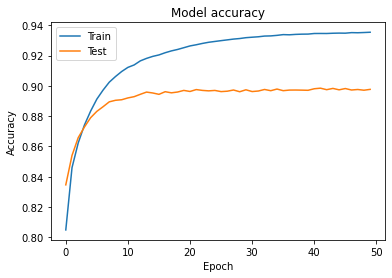

In [64]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

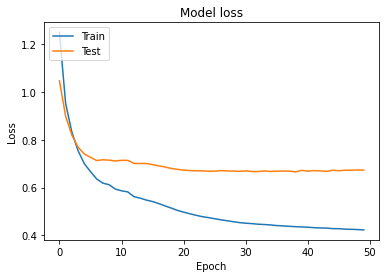

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8) 루브릭

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.

구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.


2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.

seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.


3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.

테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.

9) 회고

- 이번 프로젝트에서 **어려웠던 점,**

정확하게 이해하지 못해 아직은 추상적인 개념들이 있고 그 과정들이 복잡한것 같다.


- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**

번역기라는게 굉장히 복잡한 회로를 가지고 있다는 점을 알게 되었다. 구글, 대단해!

같은 조건일지라도 매번 할때마다 acc와 loss가 다른데 경향성마저도 다른것 같다. 이해하고 싶다.


- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**

파라미터들을 조정해보았다.


- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**


- **자기 다짐**

나름 언어에 대한 끼가 있다고 생각했는데 NLP 노드를 할때마다 아닌것 같다는 생각이 든다. 겸손해야겠다.